# Crew Dragon Demo-2 telemetry analysis

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

## Symbol analysis

This part of the notebook examines the symbols, which have been obtained using `crewdragon.grc` and a one-second snippet of the recording where the signal is particularly strong, so that there are few bit errors.

In [2]:
x = np.fromfile('crewdragon2_symbols.f32', dtype = 'float32')[200:]

The figure below only shows a portion of the symbols.

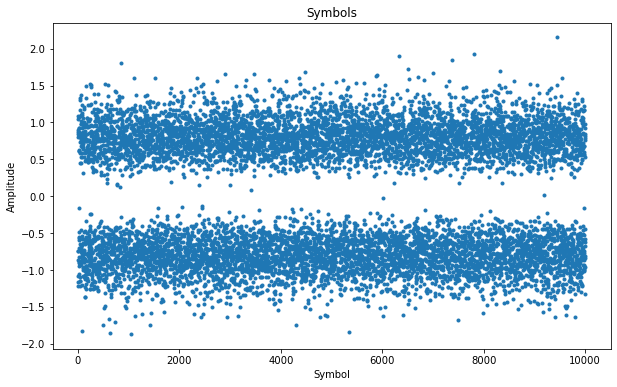

In [3]:
plt.figure(figsize = (10,6), facecolor = 'w')
plt.plot(x[:10000], '.')
plt.title('Symbols')
plt.ylabel('Amplitude')
plt.xlabel('Symbol');

We correlate against the CCSDS ASM to find the start of frames.

In [4]:
sync = '1ACFFC1D'
sync_bits = 2*np.unpackbits(np.frombuffer(bytes.fromhex(sync), dtype = 'uint8')).astype('float32')-1
sync_corr = np.correlate(x, sync_bits)

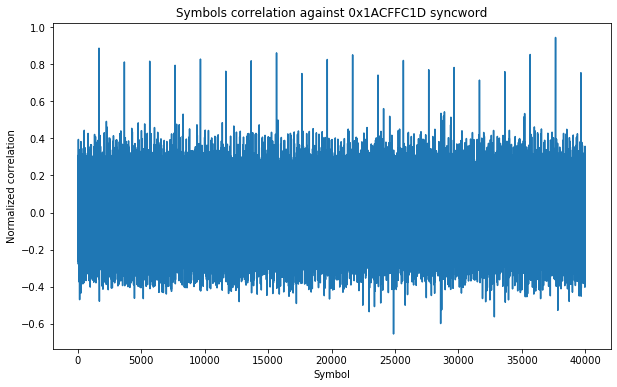

In [5]:
plt.figure(figsize = (10,6), facecolor = 'w')
plt.plot(sync_corr[:40000]/sync_bits.size)
plt.title(f'Symbols correlation against 0x{sync} syncword')
plt.ylabel('Normalized correlation')
plt.xlabel('Symbol');

The CCSDS ASM occurs every 2000 bits.

In [6]:
np.average(np.diff(np.where(sync_corr/sync_bits.size > 0.7)[0]) == 2000)

0.9905660377358491

We align the frames manually.

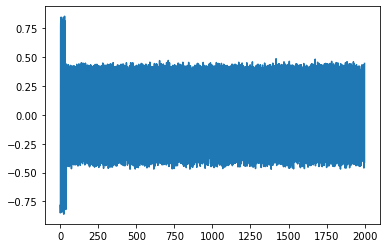

In [7]:
y = x[1660:]
y = y[:y.size//2000*2000].reshape((-1,2000))
plt.plot(np.average(y, axis = 0))

In [8]:
np.all(np.sign(np.average(y[:,:sync_bits.size], axis = 0)) == sync_bits)

True

We plot the frames. We see that many frames have the same constant pattern.

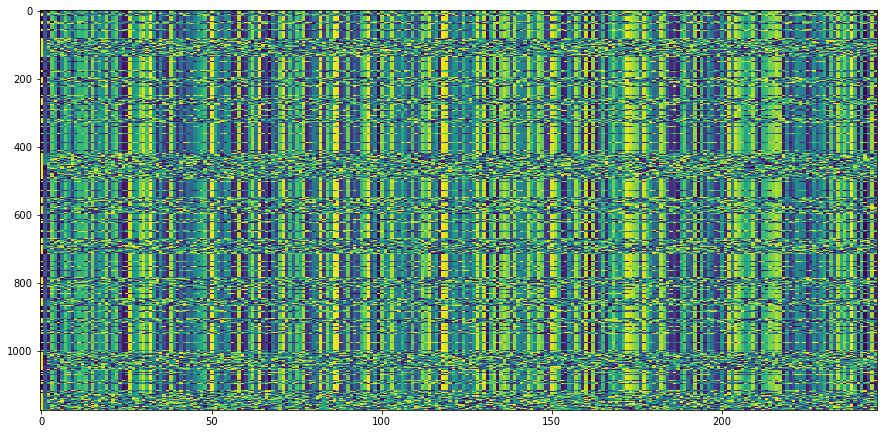

In [9]:
frames = np.packbits((y[:,32:]>0).astype('uint8'), axis = 1)

plt.figure(figsize = (15,15), facecolor = 'w')
plt.imshow(frames, aspect = 0.1)

To analyze those frames (which is full of "padding"), we take the first frame as an example.

We see that the pattern repeats every 255 bits and almost coincides with the CCSDS synchronous scrambler. This suggest that frames are scrambled and idle frames contain mainly zeros.

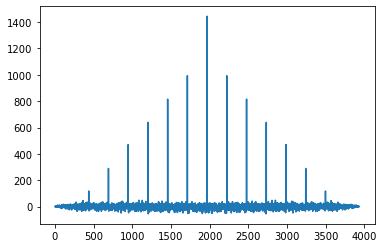

In [10]:
padding = y[0,32:]
padding_corr = np.correlate(padding, padding, mode = 'full')
plt.plot(padding_corr)

In [11]:
np.diff(np.where(padding_corr > 100)[0])

array([255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255])

In [12]:
bytes(np.packbits((padding >0).astype('uint8'))).hex()

'00480ec09a0d70bc8e2c93ada7b746ce5a977dcc32a2bf3e0a10f18894cdeab1fe901d81341ae1791c59275b4f6e8d9cb52efb9865457e7c1421e311299bd563fd203b026835c2f238b24eb69edd1b396a5df730ca8afcf82843c6225337aac7fa407604d06b85e471649d6d3dba3672d4bbee619515f9f050878c44a66f558ff480ec09a0d70bc8e2c93ada7b746ce5a977dcc32a2bf3e0a10f18894cdeab1fe901d81341ae1791c59275b4f6e8d9cb52efb9865457e7c1421e311299bd563fd203b026835c2f238b24eb69edd1b396a5df730ca8afc9cde3d50d7128427d6f7016367d4b78a01cba50e1a2ca89fcad10a9013edb0d'

## Frame analysis

This part of the notebook examines the frames obtained by decoding the full 115 second recording. Descrambling and Reed-Solomon decoding has already been done.

In [13]:
frames = np.fromfile('crewdragon2_frames.u8', dtype = 'uint8').reshape((-1,214))

The decoded frames are shown below. We see a mixture of idle and non-idle frames.

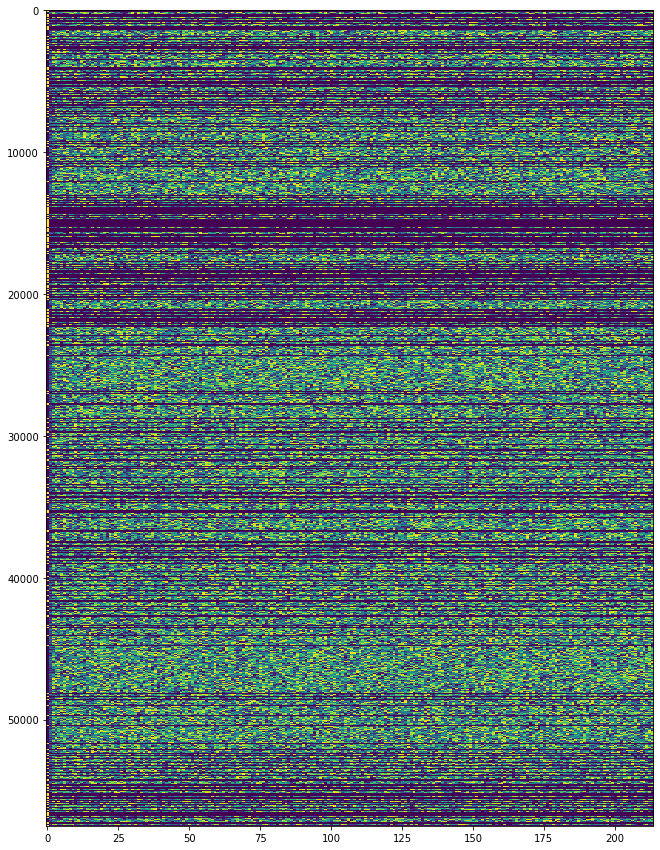

In [14]:
plt.figure(figsize = (15,15), facecolor = 'w')
plt.imshow(frames, aspect = 0.005)

Idle frames are marked by their first byte being `0xff`. We have an idle rate around 30%.

In [15]:
idle = frames[:,0] == 0xff
np.average(idle)

0.31975368772613416

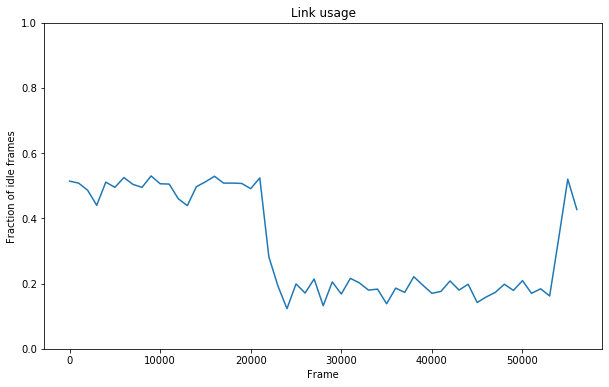

In [16]:
N = 1000
plt.figure(figsize = (10,6), facecolor = 'w')
idle_avg = np.average(idle[:idle.size//N*N].reshape((-1,N)), axis = 1)
plt.plot(np.arange(idle_avg.size)*N, idle_avg)
plt.ylim((0,1))
plt.ylabel('Fraction of idle frames')
plt.xlabel('Frame')
plt.title('Link usage');

In non-idle frames the second byte contains a 7 bit frame counter.

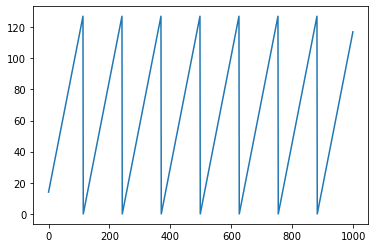

In [17]:
plt.plot(frames[~idle,1][25000:][:1000])

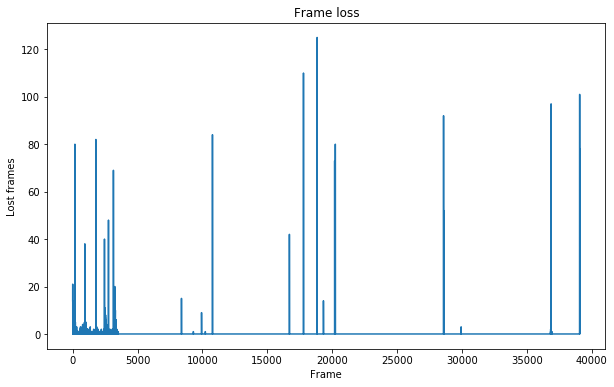

In [18]:
frame_loss = np.diff(frames[~idle,1]) % 128 - 1
plt.figure(figsize = (10,6), facecolor = 'w')
plt.plot(frame_loss)
plt.title('Frame loss')
plt.ylabel('Lost frames')
plt.xlabel('Frame');

According to the frame counter, only around 9% of the frames have been lost, however this shouldn't be trusted. For example, at the beginning of the recording no frames where decoded, and these don't enter this count.

In [19]:
np.average(frame_loss)

0.0895793376806035

We plot non-idle frames only. The data appears quite random.

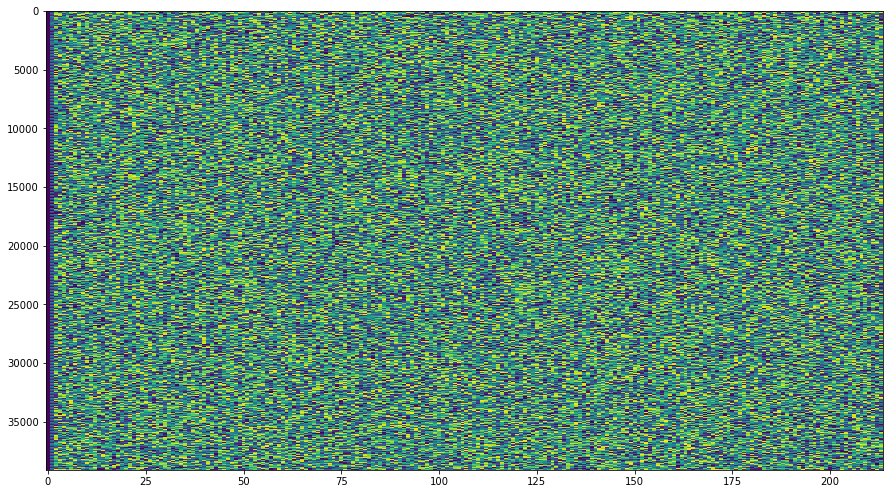

In [20]:
plt.figure(figsize = (15,15), facecolor = 'w')
plt.imshow(frames[~idle], aspect = 0.003)